## Topic Modeling: Full grid search and model finalist selection

- by Matt Jackson
- Mar. 1, 2024
- Note: Since these learning tasks are unsupervised, this is a document intended to demonstrate methods I used to generate data for manual review. The actual corpora and image/text files generated by these functions are available upon request.

### Full grid of hyperparameters that could be tuned for topic modeling grid search:
~~strikethrough~~ = not pursued for reasons of time / lack of impact

**Model-agnostic (outer loops)**
- Corpus settings (~~raw, lowercase,~~ stem, lemmatize, ~~remove NER entities~~, remove stopwords) 
    - within stopwords: default, special stopwords, all words below 2 letters
- ~~Vectorizer type: CountVectorizer, TfidfVectorizer~~ (select one appropriate to given method)
- Vectorizer setting: min_df ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 40] or so, raw frequency)
- Vecorizer setting: max-df ([0.99, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50] or so, % of documents)
- num_components ([4, 6, 8, 10, 12, 15, 20] or so)
- **Model:** LDA, NMF, K-Means, Truncated SVD k-means

**Model-specific (inner loops)**
Maybe store each of these as a named list of things to pick from, and then put those lists in a dictionary to get the grid for each model
- LDA: ~~vectorizer ([tf, tfidf]), max_iter ([5, 10, 20] or so), learning_offset (random_state should always be a known seed), learning speed (batch, online)~~
- NMF: init/beta-loss ("nndsvd" (better for sparseness) / "frobenius", "nndsvda" (needed for K-L) / "kullback-liebler" / "mu" solver,  ~~‘itakura-saito’~~, ~~regularization terms~~,)
- K-means/LSA: plain vs. TruncatedSVD (number of dimensions), ~~max_iter, n_init~~

**Set of things to export for each model:**
- plot_top_words (image of top 20 words for each topic, with frequency bar plot. **Note:** for k-means, this is text (with distance from centroid next to each word) and not an image, as existing image methods didn't adapt well)

For models being considered in more detail:
- Words-by-topic matrix (or words-by-cluster list for k-means)
- Documents-by-topic matrix (or some kind of documents-by-dominant-cluster list for k-means, if possible)

**Basic setup of nested loops for grid search**

- Initialize TextParser with desired text parser properties (incl stops)
- Generate corpus with those properties
  - Initialize vectorizer (if applicable) with vectorizer properties
    - Initialize model with model properties
      - Set num_components (if not automatically set)
        - Run this model for this num_components, and this vectorizer, on this corpus
        - Generate text and/or image file exports

At each stage, maintain a string or list of strings indicating what set of
settings is being used, and maintain those in image captions, text titles, etc.


### Potential future steps:
- get a giant list of NER output into stopwords and/or use regex to remove NER-discovered people instead of using a giant list of all expected names 
    - (it looks like that list isn't complete; at least one name in documents (`garcetti`) wasn't removed)
- For better code hygiene and reproducibility, "function-ize" a `grid_search()` wrapper procedure and inner model options as an argument (perhaps a dictionary with lists of options (values) for the hyperparameters (keys)). This way, a single instance of the wrapper can be called repeatedly with far less code and less need to customize the nested loops to each model.
- It looks like there's _always_ randomness in how these unsupervised methods produce topics, based on initialization; it's just most evident in k-means. Run each model with a larger variety of random seeds, and calculate some "variance-like" metrics to assess volatility/stability of a particular set of hyperparameters

#### Library imports

In [1]:
import pandas as pd 
import numpy as np
import nltk
nltk.download("stopwords") #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer #https://www.geeksforgeeks.org/snowball-stemmer-nlp/
stemmer = SnowballStemmer(language="english")
lemmatizer = WordNetLemmatizer()
stops = list(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
import datetime
from time import time
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import json


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text cleaning and preprocessing

Importing from the `text_parser.py` file now instead of rewriting it every time.

- Without pre-processing step, `TextParser.get_full_corpus()` runs in about 2 seconds. 
- With pre-processing step, runs in about 1 minute.
- With extra stopwords and lemmatization, it takes about 10-15 minutes.

In [2]:
from text_parser import TextParser 

# a TextParser with all stops removed
tp = TextParser(
    path="../../text_files", 
    nlp_task="topic modeling", 
    add_custom_stops=True, 
    findings_are_stops=True, 
    names_are_stops=True,
    digraphs_are_stops=True)

# At different instances of grid search, we will want different TextParser objects
# making new corpora.

# something like this will be in an outer loop before delving into model
corpus = tp.get_full_corpus(
        preprocess_input=True,
        remove_stops=True,
        stem_input=False,
        lemmatize_input=False,
        print_progress=True,
        write_to_file=False,
        write_path="../../corpora/"
    )

corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Initializing parsers for topic modeling...
Extracting text from file 0...
Extracting text from file 100...
Extracting text from file 200...
Extracting text from file 300...
Extracting text from file 400...
Extracting text from file 500...
Extracting text from file 600...
Extracting text from file 700...
Extracting text from file 800...
Extracting text from file 900...
Extracting text from file 1000...
Extracting text from file 1100...
Extracting text from file 1200...
Extracting text from file 1300...
Extracting text from file 1400...
Extracting text from file 1500...
Extracting text from file 1600...
Extracting text from file 1700...
Extracting text from file 1800...
Extracting text from file 1900...
Extracting text from file 2000...
Extracting text from file 2100...
Corpus text extraction complete


Alternately, read back in a known corpus from file, so as to minimize redundant computation

In [28]:
def corpus_from_corpus_file(filename):
    """Recover a saved corpus from a .txt file"""
    with open(filename) as f:
        corpus = f.readlines()
    return corpus 

corpus = corpus_from_corpus_file("../../corpora/corpus_lemmatized_pp_03-01-24.txt")


### Pipeline setup

#### Core functions

In [4]:
def innermost_factors(n: int):
    """Return the most compact (most 'square') way to put n items on a grid."""
    factors = []
    for i in range(1,n+1):
        if n % i == 0:
            factors.append(i)
    l = len(factors)
    if l % 2 != 0:
        return (factors[l//2], factors[l//2])
    else:
        return (factors[l//2-1], factors[l//2])

def plot_top_words(
        model, 
        feature_names,
        title="addendum",  
        # settings="Subtitle TBD",
        n_top_words=20,
        show=False):
    """
    Create a faceted chart of the top few words in each topic generated by
    a topic model. Will plot all topics in a line if number of topics is prime,
    so call n_top_words with a composite number
    """

    N = len(model.components_)
    ROWS, COLUMNS = innermost_factors(N)
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 25})
        ax.tick_params(axis="both", which="major", labelsize=min(18, 28-N)) 
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(f"LDA model - {title}", fontsize=30) 
        # plt.title(settings, fontsize=20) #TODO: this got put on the last topic's chart - why?
        #TODO: make x-axis labels closer to vertical

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    date = datetime.datetime.now().strftime("%m-%d-%y")
    plt.savefig(f"../../output/{title}_{this_model}_{N}topic_{date}.png") 
    if show:
        plt.show()

def model_text_output(
        model, 
        vectorizer, 
        vectorized,
        write_to_file=False
    ): #works for LDA, not sure it works as well for NMF or  k-means
    """
    model: LDA or similar. 
    vectorized: tf or tfidf (output of [vectorizer].fit.transform())

    return: JSON-like (dict of dicts) of topic probability by document number
    """
    doc_topic = model.transform(vectorized)

    doc_topic_export = {}
    for n in range(doc_topic.shape[0]):
        this_doc_export = {}
        this_doc_export["Topic ratings"] = ['{:.2f}'.format(i) for i in doc_topic[n]]
        this_doc_export["Top topic"] = int(doc_topic[n].argmax() + 1)
        doc_topic_export[int(n)] = this_doc_export

    word_topic_export = {}

    # word_topic = model.components_
    topic_word = np.array(model.components_).T
    feature_names = vectorizer.get_feature_names_out()

    for i, row in enumerate(topic_word):
        this_word_export = {}
        this_word_export["Topic ratings"]  = [round(j, 1) for j in row]
        # need to hard-cast to int to avoid 
        # "TypeError: Object of type 'int64' is not JSON serializable"
        this_word_export["Top topic"] = int(row.argmax() + 1)
        this_word_export["count"] = round(sum(row), 1)
        word_topic_export[feature_names[i]] = this_word_export

    if write_to_file:
        date = datetime.datetime.now().strftime("%m-%d-%y")
        with open(f"../../output/data_{model}_{date}_doc.json", "w") as f:
            json.dump(doc_topic_export, f, indent=2, sort_keys=True)
        with open(f"../../output/data_{model}_{date}_word.json", "w") as g:
            json.dump(word_topic_export, g, indent=2, sort_keys=True)    
    
    return doc_topic_export, word_topic_export

#### LDA: Single-model test run

Generating vectorizers...
Vectorizers generated in 2.2296860218048096 seconds.
Beginning fit of LDA model...
LDA model fitted in 15.132754802703857 seconds.


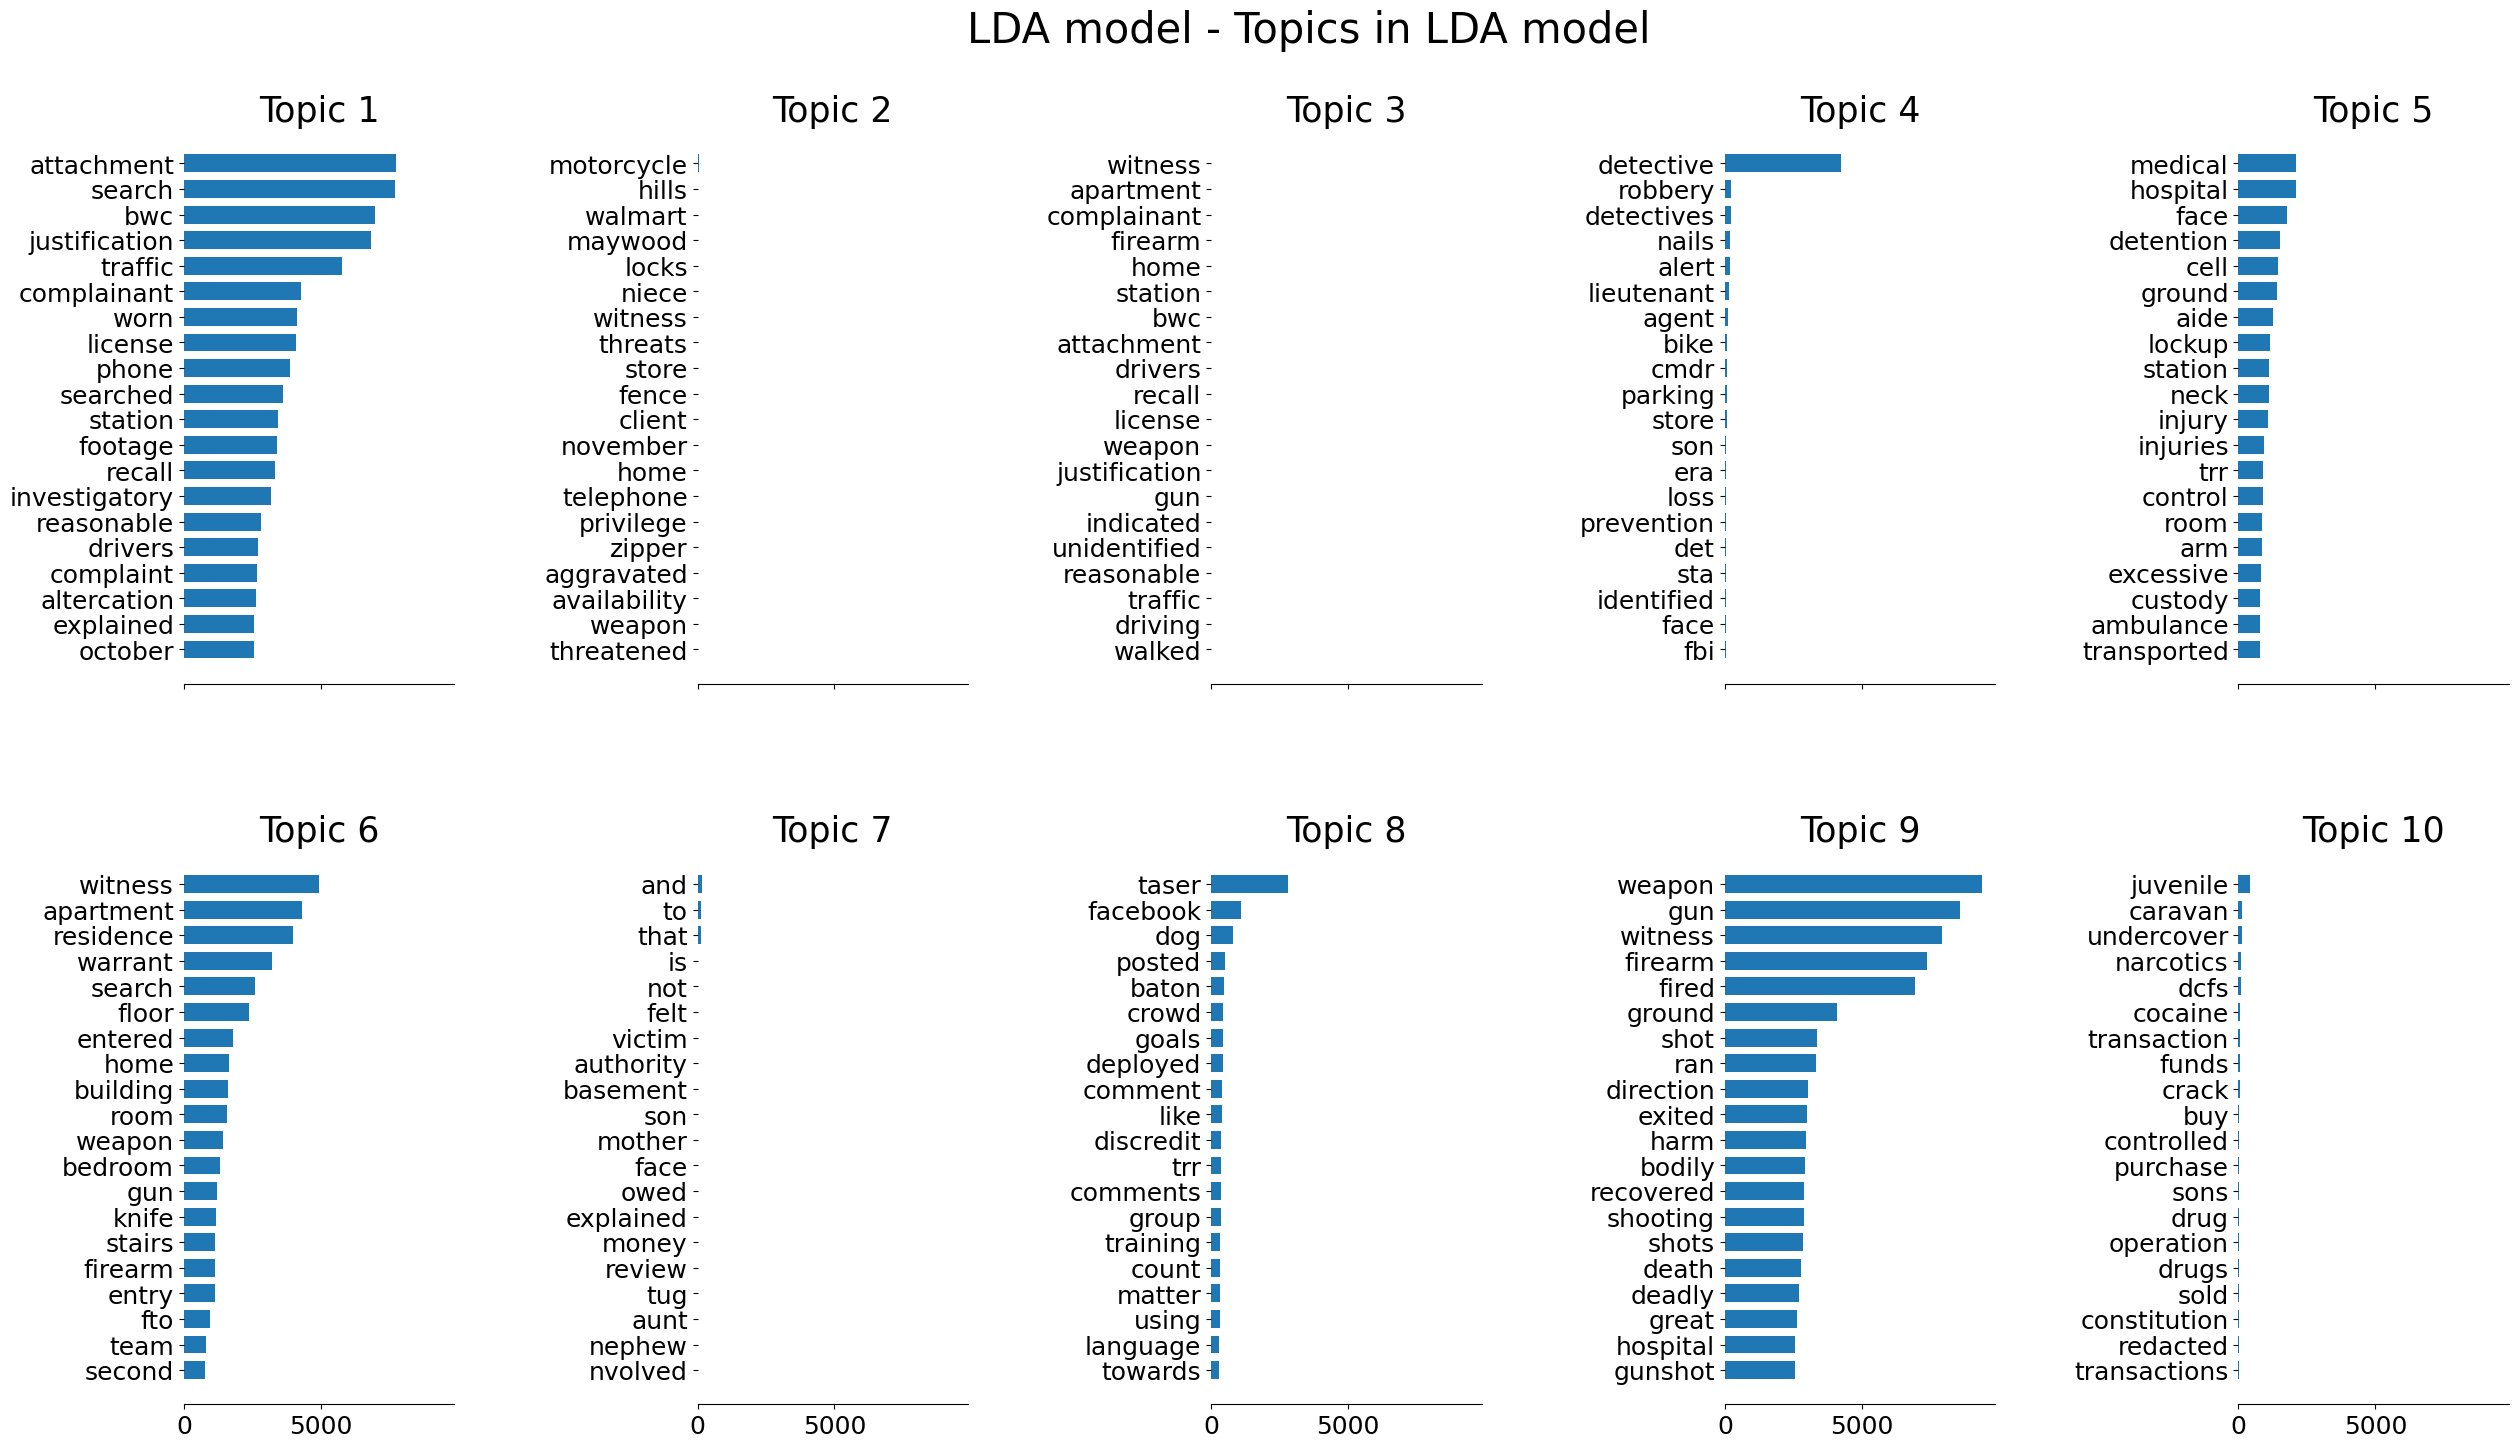

Beginning assembly of text data...
LDA text data assembled in 4.8160552978515625e-05 seconds.


In [6]:
#Stopwords will already be gone by the time you get here

MIN_DF = 5
MAX_DF = 0.5
N_COMPONENTS = 10

# For setting in settings:
# 1. Generate vectorizers
t0 = time()
print("Generating vectorizers...")

#tfidf and tf will use the same settings at same iteration of loop
tfidf_vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF)
tfidf = tfidf_vectorizer.fit_transform(corpus)
tf_vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF)
tf = tf_vectorizer.fit_transform(corpus)
#TODO: Consider export of these models to file for better archival
print(f"Vectorizers generated in {time() - t0} seconds.")

# 2. Run model
# Heavily based on and indebted to: Olivier Grisel,  Lars Buitinck, Chyi-Kwei Yau
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

lda = LatentDirichletAllocation(
    n_components=N_COMPONENTS, #tunable
    max_iter=5, #tunable
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

t0 = time()
this_model = "LDA" #Update with model used
print(f"Beginning fit of {this_model} model...")
# Best practice is to fit LDA with raw counts, not tf-idf 
# https://www.reddit.com/r/MachineLearning/comments/2vk7cy/latent_dirichlet_allocation_vs_tfidf_for_indexing/ 
# https://datascience.stackexchange.com/questions/21950/why-should-we-not-feed-lda-with-tf-idf-input
lda.fit(tf)
print(f"{this_model} model fitted in {time() - t0} seconds.")

feature_names = tf_vectorizer.get_feature_names_out()

#3. plot image

plot_top_words(lda, feature_names, f"Topics in {this_model} model", n_top_words=20,
               show=True)

# 4. Get text output for doc-to-topic and word-to-topic ratings

t0 = time()
print("Beginning assembly of text data...")

# dte, wte = model_text_output(
#     lda, tfidf_vectorizer, tf,
#     write_to_file=False)

print(f"{this_model} text data assembled in {time() - t0} seconds.")

### LDA: Big grid search

In [ ]:
#OUTERMOST LOOP: Create TextParser and properly formatted corpus
for setting in ["raw", "lemmatize", "allstops_raw", "allstops_lemmatize"]:
    setting_string = []

    t0 = time()
    print(f"Generating corpus {setting}")
    if setting == "raw":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True, #we'll always preprocess and remove basic stops
            lemmatize_input=False,
            print_progress=True,
        )
    elif setting == "lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    elif setting == "all_stops_raw":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=False,
            print_progress=True
        )
    elif setting == "all_stops_lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    print(f"Parser and corpus completed in {time() - t0} seconds.")
    
    setting_string.append(setting)

    # VECTORIZER LOOP: Initialize CountVectorizer and TfidfVectorizer
    DF_MINS = [1, 2, 5, 10, 15, 20, 40]
    DF_MAXS = [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
    for df_min in DF_MINS:
        setting_string = setting_string[:1]
        setting_string.append(f"dfmin{df_min}")
        for df_max in DF_MAXS:
            t0 = time()
            print(f"Generating vectorizers df_min={df_min}, df_max={df_max}")
            setting_string = setting_string[:2]
            setting_string.append(f"dfmax{df_max}")
            tfidf_vectorizer = TfidfVectorizer(min_df=df_min, max_df=df_max,
                                               stop_words=tp.stops)
            tfidf = tfidf_vectorizer.fit_transform(corpus)
            tf_vectorizer = CountVectorizer(min_df=df_min, max_df=df_max,
                                            stop_words=tp.stops)
            tf = tf_vectorizer.fit_transform(corpus)
            print(f"Vectorizers generateed in {time() - t0} seconds.")

            # MODEL LOOP: Run model for desired number of topics
            this_model = "LDA"
            TOPICS_NUMS = [4, 6, 8, 10, 12, 15, 20]
            for num_topics in TOPICS_NUMS:
                setting_string = setting_string[:3]
                setting_string.append(f"{this_model}_{num_topics}topic")
                t0 = time()
                print(f"Fitting LDA model for {num_topics} topics...")
                lda = LatentDirichletAllocation(
                    n_components=num_topics, 
                    max_iter=5, #tunable
                    learning_method="online",
                    learning_offset=50.0,
                    random_state=0,
                )
                lda.fit(tf)
                print(f"Model fitted in {time() - t0} seconds.")
                feature_names = tf_vectorizer.get_feature_names_out()

                setting_string_actual = "_".join(setting_string)

                plot_top_words(
                    lda, 
                    feature_names, 
                    f"Topics in {this_model} model {setting_string_actual}", 
                    n_top_words=20,
                    show=False) 
                print("Image generated")

                dte, wte = model_text_output(
                    lda, tfidf_vectorizer, tf,
                    write_to_file=False) #not worrying about this right now
                
                print(f"LDA for {num_topics} topics LOOP COMPLETE")
            print(f"df_max={df_max} LOOP COMPLETE")
        print(f"df_min={df_min} LOOP COMPLETE")
    print(f"Parser/corpus {setting} LOOP COMPLETE")
print(f"ENTIRE GRID SEARCH COMPLETE!")

Some things I learned from a giant grid search of LDA (appx. runtime - 8 hours):
- any value below about 5 for min_df does not make a perceptible difference (in the top 20 words of each topic, anyway); there may be super uncommon words that shift the balance of topics, but not by much. 
    - Raising min_df also reduces, but does not eliminate, the presence of officers' names in the top words of a topic -- it's usually still better to eliminate them altogether as stopwords.
    - Some legible topics do start to disappear as min_df rises: 
        -A topic about incidents involving a dog/animal is detectible when min_df=2 but disappears (in top 20 words anyway) above that. 
        - Similarly, a topic with several terms pertaining to digital communication (`facebook`, e.g.) seems to become less frequent above about min_df=5.
- anything above about 0.5 for max_df is way too high; for future runs, I will try values more like 0.10, 0.25, 0.30, 0.40 instead of high ones.
    - Only a few relevant words get screened out with low values of max_df: `firearm` and `car` require a value of about .75; `vehicle` about .50 -- but more precise near-synonyms are still apparent at lower level and will provide richer topic modeling and less skewed bar graphs in the facet chart anyway.
- Since LDA uses raw frequency, the most frequent word(s) in a topic can have bars that are massively longer than even the next few top words therafter. Hopefully, the idf component of NMF will make the largest bars less insanely long than the smaller ones.
- Removed all instnces of `xx`, `xxx`, ... up to nine `x`s from stopwords after this grid search, as they appear frequently near the top of some topics in almost every model



#### NMF: Big grid search

In [ ]:
#OUTERMOST LOOP: Create TextParser and properly formatted corpus
for setting in ["lemmatize", "allstops_lemmatize"]: #the "raw" settings aren't worth keeping
    setting_string = []

    t0 = time()
    print(f"Generating corpus {setting}")
    if setting == "lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    elif setting == "all_stops_lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    print(f"Parser and corpus completed in {time() - t0} seconds.")
    
    setting_string.append(setting)

    # VECTORIZER LOOP: Initialize CountVectorizer and TfidfVectorizer
    DF_MINS = [2, 5, 10, 15, 20]
    DF_MAXS = [0.1, 0.2, 0.25, 0.4, 0.5]
    for df_min in DF_MINS:
        setting_string = setting_string[:1]
        setting_string.append(f"dfmin{df_min}")
        for df_max in DF_MAXS:
            t0 = time()
            print(f"Generating vectorizers df_min={df_min}, df_max={df_max}")
            setting_string = setting_string[:2]
            setting_string.append(f"dfmax{df_max}")
            tfidf_vectorizer = TfidfVectorizer(min_df=df_min, max_df=df_max,
                                               stop_words=tp.stops)
            tfidf = tfidf_vectorizer.fit_transform(corpus)
            tf_vectorizer = CountVectorizer(min_df=df_min, max_df=df_max,
                                            stop_words=tp.stops)
            tf = tf_vectorizer.fit_transform(corpus)
            print(f"Vectorizers generateed in {time() - t0} seconds.")

            # MODEL LOOP: Run model for desired number of topics
            this_model = "NMF"
            TOPICS_NUMS = [4, 6, 8, 10, 12, 15]
            for num_topics in TOPICS_NUMS:
                setting_string = setting_string[:3]
                setting_string.append(f"{this_model}_{num_topics}topic")
                t0 = time()
                print(f"Fitting {this_model} model for {num_topics} topics...")

                # FROBENIUS
                nmf_f = NMF(
                    n_components=num_topics,
                    random_state=1,
                    init="nndsvd", 
                    beta_loss="frobenius",
                    #solver="mu",
                    l1_ratio=1,
                ).fit(tfidf)

                print(f"Frobenius model fitted in {time() - t0} seconds.")
                feature_names = tfidf_vectorizer.get_feature_names_out()

                setting_string_actual = "_".join(setting_string)

                plot_top_words(
                    nmf_f, 
                    feature_names, 
                    f"Topics in {this_model}-Frobenius model {setting_string_actual}", 
                    n_top_words=20,
                    show=False) 
                print("Image generated")

                # KULLBACK-LIEBLER
                t0 = time()
                nmf_kl = NMF(
                    n_components=num_topics,
                    random_state=1,
                    init="nndsvda", #mu solver should use nndsvdva
                    beta_loss="kullback-leibler",
                    solver="mu",
                    l1_ratio=1,
                ).fit(tfidf)
                print(f"Kullback-Liebler model fitted in {time() - t0} seconds.")

                plot_top_words(
                    nmf_kl, 
                    feature_names, 
                    f"Topics in {this_model}-Kullback-Liebler model {setting_string_actual}", 
                    n_top_words=20,
                    show=False) 
                print("Image generated")

                # Uncomment to write text output matrices to file

                # dte, wte = model_text_output(
                #     lda, tfidf_vectorizer, tf,
                #     write_to_file=False) #not worrying about this right now
                
                print(f"{this_model} for {num_topics} topics LOOP COMPLETE")
            print(f"df_max={df_max} LOOP COMPLETE")
        print(f"df_min={df_min} LOOP COMPLETE")
    print(f"Parser/corpus {setting} LOOP COMPLETE")
print(f"ENTIRE GRID SEARCH COMPLETE!")

Results were broadly similar. As before, the "Facebook/posting" topic disappears with high min_df, as does the "dog/animal" topic. This suggests a relatively low min_df value is optimal for surfacing legible topics that would otherwise not congeal.

### K-Means Single instance test 
Loops through different values of $k$; to fix it, change `TOPICS_NUMS` to a list with one integer entry in it

In [ ]:
TOPICS_NUMS = [4, 6, 8, 10, 12, 15]

tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5,
                                    stop_words=tp.stops)
tfidf = tfidf_vectorizer.fit_transform(corpus)

for num_topics in TOPICS_NUMS:
    print(f"{num_topics}-MEANS CLUSTERING (BASIC)")
    for seed in range(5):
        print(f"Seed {seed}")
        kmeans = KMeans(
            n_clusters=num_topics,
            max_iter=100,
            n_init="auto",
            random_state=seed,
        ).fit(tfidf)
        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
        print(f"Number of elements assigned to each cluster: {cluster_sizes}")

        centroids = kmeans.cluster_centers_
        order_centroids = centroids.argsort()[:, ::-1]
        terms = tfidf_vectorizer.get_feature_names_out()

        for i in range(num_topics):
            print(f"Cluster {i} (size {cluster_sizes[i]}): ", end="")
            for ind in order_centroids[i, :min(20, cluster_sizes[i])]:
                word = terms[ind]
                word_vector = tfidf_vectorizer.transform([word])
                row_index = np.where(terms == word)[0][0]
                distance = np.linalg.norm(centroids[i] - word_vector) 
                #this isn't quite right, but is at least increasing. #TODO: fix
                print(f"{word} ({distance:.4f}), ", end="")
            print()
print("\n\n")

### K-Means Clustering Big Grid Search

There is massive variability over seed initialization -- does that decrease as number of topics increases? as tfidf shrinks?

Based on and indebted to: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

Note: For this and Truncated SVD, the notebook outputs a large amount of text rather than writing it to file. Go to the output cell, click Copy Output on left hand side, paste to file, and save it if desired.

In [ ]:
#OUTERMOST LOOP: Create TextParser and properly formatted corpus
for setting in ["lemmatize", "allstops_lemmatize"]:
    setting_string = []

    t0 = time()
    print(f"Generating corpus {setting}")
    if setting == "lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    elif setting == "all_stops_lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    print(f"Parser and corpus completed in {time() - t0} seconds.")
    
    setting_string.append(setting)

    # VECTORIZER LOOP: Initialize TfidfVectorizer
    DF_MINS = [2, 5, 10, 15, 20]
    DF_MAXS = [0.1, 0.2, 0.25, 0.4, 0.5]
    for df_min in DF_MINS:
        setting_string = setting_string[:1]
        setting_string.append(f"dfmin{df_min}")
        for df_max in DF_MAXS:
            t0 = time()
            print(f"Generating vectorizer df_min={df_min}, df_max={df_max}")
            setting_string = setting_string[:2]
            setting_string.append(f"dfmax{df_max}")
            tfidf_vectorizer = TfidfVectorizer(min_df=df_min, max_df=df_max,
                                               stop_words=tp.stops)
            tfidf = tfidf_vectorizer.fit_transform(corpus)
            print(f"Vectorizer generateed in {time() - t0} seconds.")

            # MODEL LOOP: Run model for desired number of topics
            for num_topics in TOPICS_NUMS:
                print(f"{num_topics}-MEANS CLUSTERING (BASIC)")
                for seed in range(5):
                    print(f"Seed {seed}")
                    kmeans = KMeans(
                        n_clusters=num_topics,
                        max_iter=100,
                        n_init="auto",
                        random_state=seed,
                    ).fit(tfidf)
                    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
                    print(f"Number of elements assigned to each cluster: {cluster_sizes}")

                    centroids = kmeans.cluster_centers_
                    
                    order_centroids = centroids.argsort()[:, ::-1]
                    terms = tfidf_vectorizer.get_feature_names_out()

                    for i in range(num_topics):
                        print(f"Cluster {i} (size {cluster_sizes[i]}): ", end="")
                        for ind in order_centroids[i, :min(20, cluster_sizes[i])]:
                            word = terms[ind]
                            word_vector = tfidf_vectorizer.transform([word])
                            row_index = np.where(terms == word)[0][0]
                            distance = np.linalg.norm(centroids[i] - word_vector) 
                            #this isn't quite right, but is at least increasing. #TODO: fix
                            print(f"{word} ({distance:.4f}), ", end="")
                        print()

            print(f"df_max={df_max} LOOP COMPLETE")
        print(f"df_min={df_min} LOOP COMPLETE")
    print(f"Parser/corpus {setting} LOOP COMPLETE")
print(f"ENTIRE GRID SEARCH COMPLETE!")

Notes on basic k-means clustering grid search:
- Issue: there's no particular ordering to the clusters. This causes some reproducibility issues. It may make sense to sort the cluster sizes from largest to smallest to see if the behavior is returning clusters of roughly the same size, and then the top words from each to make sure the clusters of roughly the same size contain roughly the same content.
    - They don't; the clusters are wildly volatile in size and content based on the initialization seed. (the `taser` cluster may have 74 items in it one iteration, and 534 the next.) Plus, it frequently assigns individual words to a singleton cluster even when $k$ is low, which is especially bad. This is mitigated, but nowhere close to fully eliminated, at higher values of df_min .
    -Note, though, that there is randomization in the NMF and LDA methods too; it's just hidden in this implementation by setting a seed up front. If time permits, run loops to see how different those are with different initialization seeds before commenting on differences between techniques.

So, truncated SVD is necessary -- what amount of truncation works best?

### Truncated SVD K-Means / Latent Semantic Analysis (LSA)

Do truncated SVD for dimensionality reduction ("latent semantic analysis"), making k-means results more stable and less prone to Curse of Dimensionality.

Inspired by and indebted to: "Ioana", "Latent Semantic Analysis: intuition, math, implementation" (May 10, 2020), https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jor', 'mal', 'yushu'] not in stop_words.
  warnings.warn(


<AxesSubplot: >

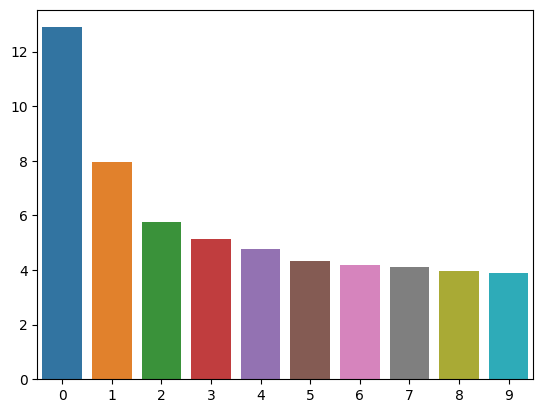

In [138]:
import seaborn as sns

LATENT_DIMS = [5, 10, 20, 40, 100, 200, 1000]

tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5,
                                    stop_words=tp.stops)
tfidf = tfidf_vectorizer.fit_transform(corpus)

lsa_obj = TruncatedSVD(n_components=10, n_iter=100, random_state=0)
lsa_data = lsa_obj.fit_transform(tfidf)
Sigma = lsa_obj.singular_values_
V_T = lsa_obj.components_.T

sns.barplot(x=list(range(len(Sigma))), y = Sigma)

Get a matrix of terms by place in latent concept space (greater value for a latent concept $\rightarrow$ more strongly associated with it?)

In [139]:
term_topic_matrix = pd.DataFrame(data=V_T,
                                 index=tfidf_vectorizer.get_feature_names_out(),
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])
term_topic_matrix

,Latent_concept_0,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9
aaf,0.000028,-0.000033,-0.000010,0.000092,0.000005,-0.000032,0.000078,-0.000027,-0.000068,-0.000015
aand,0.000116,0.000075,0.000023,-0.000103,0.000267,-0.000499,-0.000108,-0.000092,0.000253,-0.000346
aaronson,0.000293,-0.000172,-0.001209,0.000154,-0.000868,-0.000422,0.001473,0.001704,-0.000561,-0.000879
aau,0.000228,0.000692,0.000349,-0.000146,-0.000232,0.000249,-0.000244,0.000283,-0.000070,0.000029
aback,0.000144,-0.000222,0.000368,-0.000418,-0.000277,0.000677,0.000376,-0.000259,-0.000091,-0.000045
...,...,...,...,...,...,...,...,...,...,...
zulu,0.000710,-0.000174,0.000654,-0.000258,0.000464,-0.001580,0.001020,-0.000586,0.000347,0.001673
zyk,0.000275,-0.000370,0.000380,-0.000271,0.000280,-0.000061,0.001109,-0.000566,0.000849,-0.000766
zzi,0.000092,-0.000102,-0.000155,-0.000161,0.000150,-0.000521,-0.000130,-0.000108,-0.000050,-0.000181
zzle,0.000143,0.000327,0.000143,-0.000131,-0.000099,0.000117,-0.000023,-0.000025,-0.000087,-0.000101


Change value of i to see top terms along that latent concept axis

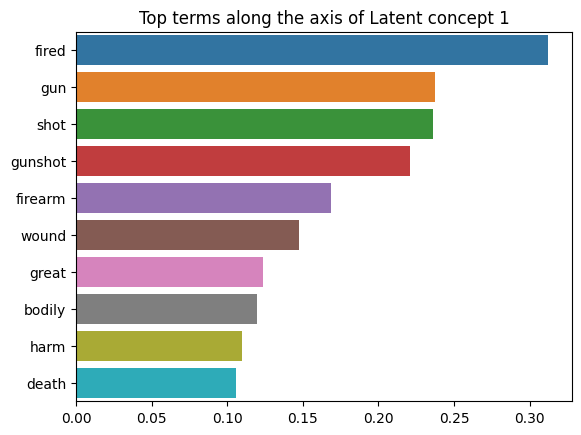

In [141]:
i=1 
data = term_topic_matrix[f'Latent_concept_{i}']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title(f'Top terms along the axis of Latent concept {i}')
fig = sns.barplot(x= top_10.values, y=top_10.index)

The first few latent axes track pretty closely with legible topics. Let's see how the clustering goes in latent space.

### LSA (Truncated SVD) K-means: Single instance test

In [219]:
#do we actually want the Normalizer to be there? Yes we do
lsa = make_pipeline(TruncatedSVD(n_components=10), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

V_T = lsa[0].components_.T #vectors for each word in reduced-dimensional space

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

NUM_CLUSTERS=10

for seed in range(5):
    print(f"\nSeed {seed}")
    kmeans_lsa = KMeans(
        n_clusters=NUM_CLUSTERS,
        max_iter=100,
        n_init=1,
        random_state=seed
    ).fit(X_lsa)
    cluster_ids, cluster_sizes = np.unique(kmeans_lsa.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
    print(f"Sorted: {sorted(cluster_sizes)}")

    centroids = kmeans_lsa.cluster_centers_ 

    original_space_centroids = lsa[0].inverse_transform(centroids)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()

    for i in range(NUM_CLUSTERS):
        print(f"Cluster {i} (size {cluster_sizes[i]}): ", end="")
        for ind in order_centroids[i, :20]:
                word = terms[ind]
                # figure out where word lives in reduced-dimension space and
                # subtract that from reduced-dimension centroid to get distance
                word_vector = V_T[ind]
                # Note: distances in original space are not strictly increasing from
                # smallest to highest, whereas in latent space they would be
                distance = np.linalg.norm(kmeans_lsa.cluster_centers_[i] - word_vector) 
                print(f"{word} ({distance:.4f}), ", end="")
        print()


LSA done in 0.355 s
Explained variance of the SVD step: 14.3%

Seed 0
Number of elements assigned to each cluster: [176 293 324 298  77 134  70 272 232 272]
Sorted: [70, 77, 134, 176, 232, 272, 272, 293, 298, 324]
Cluster 0 (size 176): accountability (0.5053), justification (0.6012), bwc (0.6458), firearm (0.8718), ground (0.6489), modified (0.6358), handcuff (0.6440), excessive (0.6384), arm (0.6508), search (0.8525), station (0.6506), face (0.6564), complainant (1.0966), hospital (0.6687), footage (0.6503), september (0.6492), medical (0.6621), effective (0.6560), review (0.6558), control (0.6583), 
Cluster 1 (size 293): traffic (0.6061), license (0.6600), justification (0.7673), bwc (0.7786), citation (0.7574), plate (0.7761), passenger (0.7774), driving (0.7796), ticket (0.7929), complainant (1.1840), search (0.9671), investigatory (0.8172), searched (0.8399), light (0.8173), station (0.8253), phone (0.8349), suspended (0.8286), worn (0.8339), issued (0.8291), isr (0.8396), 
Cluste

- You can see that, when dimension is sufficiently low, the variation is mitigated and clusters stay legible. (Though their order is not fixed and depends on initialization point.)
    - When that is the case, the cluster corresponding to each major concept is roughly the same size with each iteration.
- This suggests that applying Truncated SVD for dimensionality reduction has a substantial improving effect on the legibility and consistency of clusters, i.e. that the latent concept dimensions from LSA correspond to "real" semantic ideas shared by words.

#### Truncated SVD/LSA K-Means Grid Search

In [ ]:
#OUTERMOST LOOP: Create TextParser and properly formatted corpus
for setting in ["lemmatize", "allstops_lemmatize"]:
    setting_string = []

    t0 = time()
    print(f"Generating corpus {setting}")
    if setting == "lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    elif setting == "all_stops_lemmatize":
        tp = TextParser(path="../../text_files", nlp_task="topic modeling",
                        add_custom_stops=True, findings_are_stops=True, 
                        names_are_stops=True, digraphs_are_stops=True)
        corpus = tp.get_full_corpus(
            preprocess_input=True,
            lemmatize_input=True,
            print_progress=True
        )
    print(f"Parser and corpus completed in {time() - t0} seconds.")
    
    setting_string.append(setting)

    # VECTORIZER LOOP: Initialize TfidfVectorizer
    DF_MINS = [2, 5, 10, 15, 20]
    DF_MAXS = [0.1, 0.2, 0.25, 0.4, 0.5]
    for df_min in DF_MINS:
        setting_string = setting_string[:1]
        setting_string.append(f"dfmin{df_min}")
        for df_max in DF_MAXS:
            t0 = time()
            print(f"Generating vectorizer df_min={df_min}, df_max={df_max}")
            setting_string = setting_string[:2]
            setting_string.append(f"dfmax{df_max}")
            tfidf_vectorizer = TfidfVectorizer(min_df=df_min, max_df=df_max,
                                               stop_words=tp.stops)
            tfidf = tfidf_vectorizer.fit_transform(corpus)
            print(f"Vectorizer generateed in {time() - t0} seconds.")

            # MODEL LOOP: Run model for desired number of topics
            for NUM_DIMS in [5, 10, 20, 50, 100, 500, 1000]:

                lsa = make_pipeline(TruncatedSVD(n_components=NUM_DIMS), 
                                    Normalizer(copy=False))
                t0 = time()
                X_lsa = lsa.fit_transform(tfidf)
                explained_variance = lsa[0].explained_variance_ratio_.sum()

                V_T = lsa[0].components_.T #vectors for each word in reduced-dimensional space

                print(f"LSA done in {time() - t0:.3f} s")
                print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

                for NUM_CLUSTERS in [4, 6, 8, 10, 12, 15]:
                    for seed in range(5):
                        print(f"\nSeed {seed}")
                        kmeans_lsa = KMeans(
                            n_clusters=NUM_CLUSTERS,
                            max_iter=100,
                            n_init=1,
                            random_state=seed
                        ).fit(X_lsa)
                        cluster_ids, cluster_sizes = np.unique(kmeans_lsa.labels_, return_counts=True)
                        print(f"Number of elements assigned to each cluster: {cluster_sizes}")
                        print(f"Sorted: {sorted(cluster_sizes)}")

                        centroids = kmeans_lsa.cluster_centers_ 

                        original_space_centroids = lsa[0].inverse_transform(centroids)
                        order_centroids = original_space_centroids.argsort()[:, ::-1]
                        terms = tfidf_vectorizer.get_feature_names_out()

                        for i in range(NUM_CLUSTERS):
                            print(f"Cluster {i} (size {cluster_sizes[i]}): ", end="")
                            for ind in order_centroids[i, :min(20, cluster_sizes[i])]:
                                    word = terms[ind]
                                    # figure out where word lives in reduced-dimension space and
                                    # subtract that from reduced-dimension centroid to get distance
                                    word_vector = V_T[ind]
                                    # distances in latent space are not strictly increasing from
                                    # smallest to highest, whereas in original space they would be
                                    distance = np.linalg.norm(kmeans_lsa.cluster_centers_[i] - word_vector) 
                                    print(f"{word} ({distance:.4f}), ", end="")
                            print()
                    print(f"{NUM_CLUSTERS}-means clustering LOOP COMPLETE")
                print(f"{NUM_DIMS}-dimensional reduction LOOP COMPLETE")
            print(f"df_max={df_max} LOOP COMPLETE")
        print(f"df_min={df_min} LOOP COMPLETE")
    print(f"Parser/corpus {setting} LOOP COMPLETE")
print(f"ENTIRE GRID SEARCH COMPLETE!")

Results are promising. In selecting a final model, truncated-SVD LSA k-means with a relatively low number of dimensions should help with surfacing meaningful topics in a latent concept space.